# Macro data analysis (car flows)
This code analyses the daily flow data provided by Utrecht. The produced plots show the overview over two months.
#### Requirements
I ran the code on Google Colab and there I created the following folder structure: \\
Colab Notebooks/PDM/Flow_data and placed there the data and the code \\
Colab Notebooks/PDM/Saved plots/Flows and saved there my figures

Data: 
- car flow data: provided by Utrecht, period 1.03.-1.05.2022, in csv format

the data file needs to be in the same folder as the code

In [1]:
#packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

#google drive connection
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### Data import

In [2]:
#daily data for VRI 61 to 90 from January to April 2022
daily_90 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/PDM/Flow_data/IND_12_VRI_061_tm_090_per_day.csv', sep = ';')
#display(daily_90.head(10))
#daily data for VRI 91 to 128 from January to April 2022
daily_128 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/PDM/Flow_data/IND_12_VRI_091_tm_128_per_day.csv', sep = ';')


## Information about daily data


In [3]:
veh_type = daily_90.Voertuig.unique()
print('Vehicle types:{}'.format(veh_type))
day_type = daily_90.Dagtype.unique()
print('Type of days: {}'.format(day_type))
print('Types of time period:{}'.format(daily_90.Tijdvak.unique()))
daily_90.Datum = [datetime.datetime.strptime(daily_90.Datum[i], '%d.%m.%y') for i in range(len(daily_90.Datum))]
daily_128.Datum = [datetime.datetime.strptime(daily_128.Datum[i], '%d.%m.%y') for i in range(len(daily_128.Datum))]
print('First date: {}'.format(daily_90.Datum.min()))
print('Last date: {}'.format(daily_90.Datum.max()))

Vehicle types:['auto' 'fiets' 'bus']
Type of days: ['werkdag' 'weekend']
Types of time period:['7-9 uur' '9-16 uur' '16-18 uur' '18-7 uur' '7-19 uur' 'etmaal']
First date: 2021-06-01 00:00:00
Last date: 2022-05-01 00:00:00


#### Different kind of plots
Location:
- VRI: 90, 89, 111
- signal group
- lane (Rijstrook)

Time period: 
- weekdays *average* over March + April (representative months without Covid regulations)
- every weekday over March + April


Moment of the day:
- morning rush hour: 7-9 uur
- evening rush hour: 16-18 uur
- day traffic: 7-19 uur (or the whole day: eetmal)


#### Identification of vris, approaches 

In [4]:
#car specific variables
#-----------------------
vris = [111, 89, 90]
#signalgroup IDs belonging to bikes and outflows can be found in the excel provided by Utrecht
signalgroups_bikes = {89: [22, 24, 26, 28, 82, 83, 86], 
                     90: [22, 23, 24, 26, 27, 82, 86],
                     111: [82, 86, 88]}
signalgroups_outflows ={89:[1011, 2011, 1002, 1005, 2005, 2008, 3008],
                        90: [51, 71, 1022, 1024, 1026, 1028, 1082, 1086],
                        111: [1086, 7, 9, 24, 26, 45, 62, 64, 65, 66, 68, 70, 71, 75]}
#movements which I will omit to improve readability are also grouped in signalgroups_outflows like 7 and 9 


### Data preprocessing

In [5]:
#dict initialisation
car_d = {v:[] for v in vris}
signalgroups = {v:[] for v in vris}
for vri in vris: 
    #car data=====
    if vri == 111:
      car_d[vri] = daily_128[daily_128.Vri == vri]
    else:    
      car_d[vri] = daily_90[daily_90.Vri == vri]
    #only keep March + April
    car_d[vri] = car_d[vri].drop(car_d[vri][car_d[vri].Datum < '2022-03-01'].index)
    #remove weekends and public holiday
    car_d[vri] = car_d[vri].drop(car_d[vri][car_d[vri].Dagtype == 'weekend'].index)
    car_d[vri] = car_d[vri].drop(car_d[vri][car_d[vri].Vakantiedag == 'ja'].index)
    #omit bicycles for now
    for sg in signalgroups_bikes[vri]:
        car_d[vri] = car_d[vri].drop(car_d[vri][car_d[vri].Signaalgroep == sg].index)
    #omit outflows 
    for sg in signalgroups_outflows[vri]:
        car_d[vri] = car_d[vri].drop(car_d[vri][car_d[vri].Signaalgroep == sg].index)
    signalgroups[vri] = car_d[vri].Signaalgroep.unique()

### Plots 
#### [2 months dataset]
- daily intensities
- morning rush hour
- evening rush hour

#### Design:
- intersection 89: has 4 approaches 2, 5, 8, 11
- intersection 90: has separate left turns, but with low flows, so I take the sum to also accord it to 2, 5, 8, and 11
- intersection 111 (socrateslaan) is a quite large itnersection. For the continuation with the queuelength data I will only consider the main road, and omit the smaller roads which have anyways smaller flows. that are 5 and 6 from the west, and 11 and 12 from the east. again the left turn (6 and 12) is added to the other

In [6]:
print(car_d[89].Tijdvak.unique())
time_int = ['7-19 uur', '7-9 uur', '16-18 uur']

['7-9 uur' '9-16 uur' '16-18 uur' '18-7 uur' '7-19 uur' 'etmaal']


#### Color scheme for roads

In [7]:
cmap = plt.cm.get_cmap('Pastel1', 10)    # PiYG

for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    print(matplotlib.colors.rgb2hex(rgba))

#fbb4ae
#b3cde3
#ccebc5
#decbe4
#fed9a6
#ffffcc
#e5d8bd
#e5d8bd
#f2f2f2
#f2f2f2


In [8]:
#color dict for the approachs as on visualisation made on powerpoint
c_roads = {89: {2: '#fbb4ae', 5: '#b3cde3', 8: '#ccebc5', 11: '#decbe4'} , 
          90:{2: '#fbb4ae', 3: '#fbb4ae', 5: '#b3cde3', 6:'#b3cde3', 8: '#ccebc5', 9: '#ccebc5', 11: '#decbe4', 12: '#decbe4'}, 
          111: {2: '#fbb4ae', 5: '#b3cde3', 8: '#ccebc5', 11: '#decbe4'}}

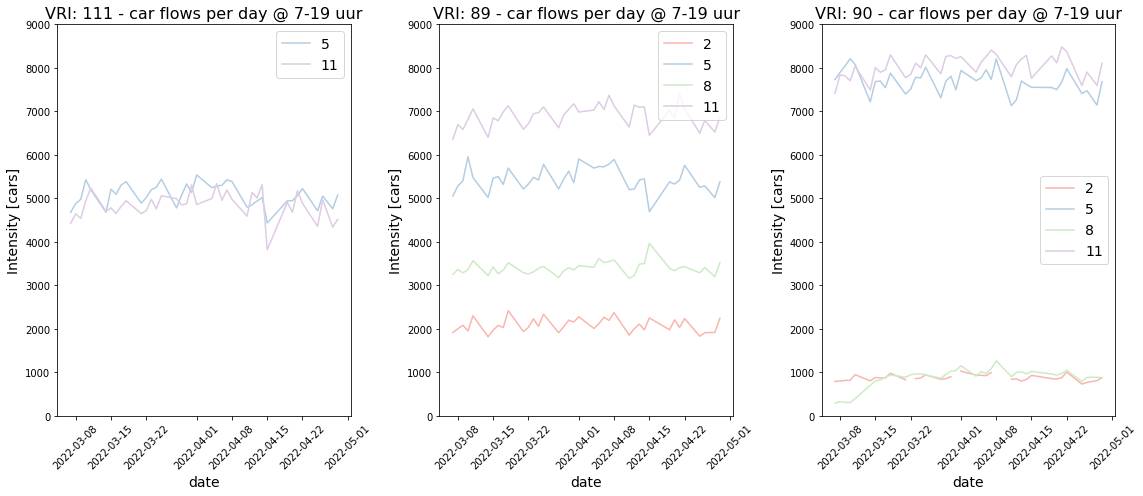

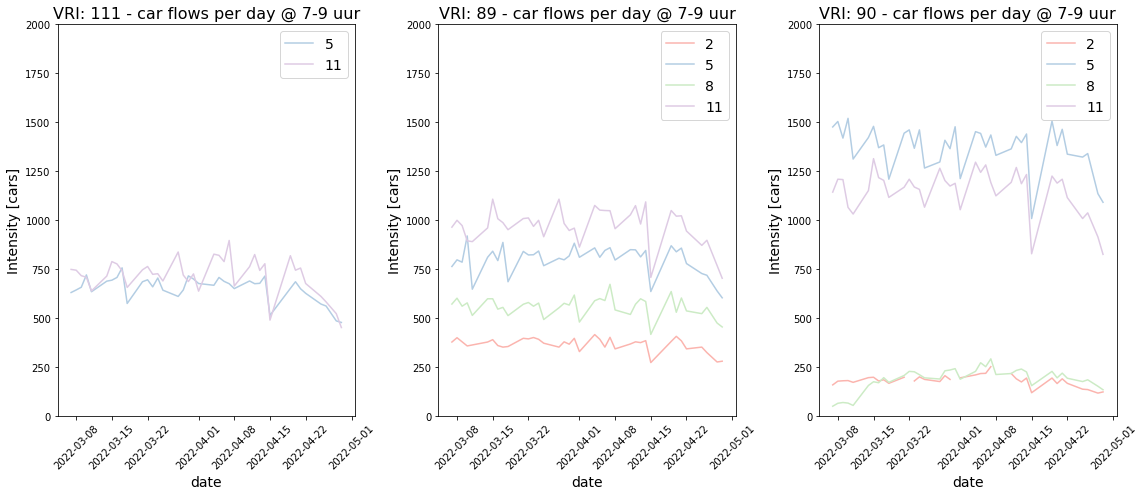

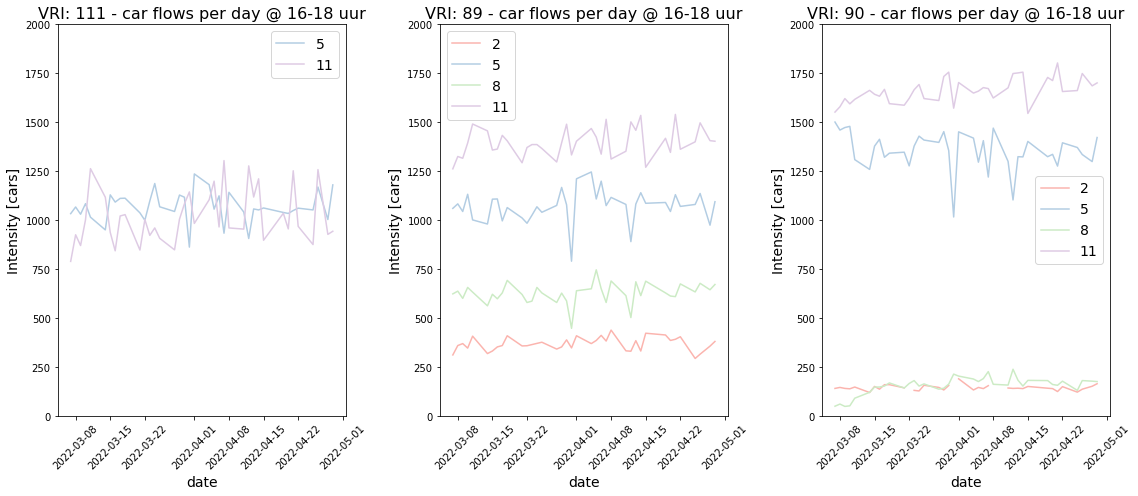

In [9]:
#plot daily intensities

for index_t, t_int in enumerate(time_int):
    fig = plt.figure(figsize=(16,7))
    for index_vri,vri in enumerate(vris):
        ax= plt.subplot(1,len(vris),index_vri+1)
        if t_int == '7-19 uur':
            ax.set_ylim(0,9000)
        else:
            ax.set_ylim(0,2000)
        ax.set_xlabel('date', fontsize = 14)
        ax.set_ylabel('Intensity [cars]', fontsize = 14)
        plt.setp(ax.get_xticklabels(), rotation=45)
        ax.set_title('VRI: {} - car flows per day @ {}'.format(vri, t_int), fontsize = 16)
        for sg in [2, 5, 8, 11]:
            df1 = car_d[vri].loc[(car_d[vri].Signaalgroep == sg) & (car_d[vri].Tijdvak == t_int)]
            df1 = df1.set_index('Datum')
            #also consider neighbouring movements (left turns)
            df2 = car_d[vri].loc[(car_d[vri].Signaalgroep == sg+1) & (car_d[vri].Tijdvak == t_int)]
            df2 = df2.set_index('Datum')
            #add flow of leftturns
            if not df2.empty:
                df1 = df1.align(df2)[0]
                df2 = df1.align(df2)[1]
                intensity = df1['TijdvakIntensiteit'].values + df2['TijdvakIntensiteit'].values
                time = df1.index.values
                ax.plot(time, intensity, color = c_roads[vri][sg], label = sg )
            elif not df1.empty:
                intensity = df1['TijdvakIntensiteit'].values
                time = df1.index.values
                ax.plot(time, intensity, color = c_roads[vri][sg], label = sg )
            else:
              pass
        ax.legend(loc='best', fontsize = 14)
    fig.tight_layout()
    #save figure
    fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/PDM/Saved plots/Flows/carflows_2months_{}.pdf'.format(t_int))
    

Directions:
- 2 is south-north
- 5 is west-east
- 8 is north-south
- 11 is east-west


#### find the day with the total maximum car intensity


In [10]:
dates = car_d[89].Datum.unique()
max_day = {v:{t:{} for t in time_int} for v in vris}
for vri in vris:
    for t_int in time_int:
        max_day[vri][t_int] = [0,0]
        for date in dates:
            #sum all intensities per day 
            sum_day = car_d[vri][car_d[vri].Datum == date][car_d[vri].Tijdvak == t_int].TijdvakIntensiteit.sum()
            if sum_day > max_day[vri][t_int][1]:
                max_day[vri][t_int] = [str(date.astype('datetime64[D]')), sum_day]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [11]:
max_day

{111: {'7-19 uur': ['2022-04-05', 10622],
  '7-9 uur': ['2022-04-07', 1571],
  '16-18 uur': ['2022-04-26', 2427]},
 89: {'7-19 uur': ['2022-04-08', 18974],
  '7-9 uur': ['2022-04-07', 2980],
  '16-18 uur': ['2022-04-04', 3732]},
 90: {'7-19 uur': ['2022-04-08', 18539],
  '7-9 uur': ['2022-04-04', 3184],
  '16-18 uur': ['2022-04-01', 3546]}}

In [12]:
sum_vris = {v: {t: {d: [] for d in dates} for t in time_int} for v in vris}
sum_p_day = {t: {d: [] for d in dates} for t in time_int}

for vri in vris:
    for t_int in time_int:
        for date in dates:
            #sum all intensities per day 
            #display(car_d[vri][car_d[vri].Datum == date][car_d[vri].Tijdvak == t_int])
            sum_vris[vri][t_int][date] = car_d[vri][car_d[vri].Datum == date][car_d[vri].Tijdvak == t_int].TijdvakIntensiteit.sum()

#display(sum_vris[89]['16-18 uur'])
#display(sum_p_day['16-18 uur'])
for t in time_int:
  for vri in vris:
    for d in dates:
      sum_p_day[t][d] =+ sum_vris[vri][t][d]

print(sum_p_day[t])

for t in time_int: 
  print('{}: max is {} on the {}'.format(t, np.max(sum_p_day[t].values), np.argmax(sum_p_day[t]) ))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


{numpy.datetime64('2022-03-07T00:00:00.000000000'): 3242, numpy.datetime64('2022-03-08T00:00:00.000000000'): 3244, numpy.datetime64('2022-03-09T00:00:00.000000000'): 3282, numpy.datetime64('2022-03-10T00:00:00.000000000'): 3262, numpy.datetime64('2022-03-11T00:00:00.000000000'): 3163, numpy.datetime64('2022-03-14T00:00:00.000000000'): 3161, numpy.datetime64('2022-03-15T00:00:00.000000000'): 3318, numpy.datetime64('2022-03-16T00:00:00.000000000'): 3329, numpy.datetime64('2022-03-17T00:00:00.000000000'): 3300, numpy.datetime64('2022-03-18T00:00:00.000000000'): 3264, numpy.datetime64('2022-03-21T00:00:00.000000000'): 3219, numpy.datetime64('2022-03-22T00:00:00.000000000'): 3138, numpy.datetime64('2022-03-23T00:00:00.000000000'): 3354, numpy.datetime64('2022-03-24T00:00:00.000000000'): 3401, numpy.datetime64('2022-03-25T00:00:00.000000000'): 3349, numpy.datetime64('2022-03-28T00:00:00.000000000'): 3289, numpy.datetime64('2022-03-29T00:00:00.000000000'): 3459, numpy.datetime64('2022-03-30T0